In [5]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb
plb.rcParams['pdf.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


In [1]:
import group_data as gd
#file_name = 'nnls_fits_no_bk_dF_F_sig_mtrx.cpkl',
#flylist = [gd.GMR22H05_pr_swarm.flies+gd.GMR22H05_prc_swarm.flies+ gd.GMR22H05_swarm.flies][0]
#flylist = gd.get_update_list(swarms = [gd.GMR22H05_pr_swarm,gd.GMR22H05_prc_swarm, gd.GMR22H05_swarm],
#                             file_name = 'nnls_fits_bk_sub_F_sig_mtrx.cpkl',
#                             replace = True)
flylist = gd.swarms['GMR40D04_yr'].flies

In [28]:
trial_list = ['step_roll_yaw_%03d'%(i) for i in range(0,360,30)]
trial_to_label = dict()
[trial_to_label.update({tname:str(lbl)}) for tname,lbl in zip(trial_list,range(0,360,30))]
trial_to_label['step_roll_yaw_000'] = 'RL'
trial_to_label['step_roll_yaw_090'] = 'YR'
trial_to_label['step_roll_yaw_180'] = 'RR'
trial_to_label['step_roll_yaw_270'] = 'YL'
trial_to_label

{'step_roll_yaw_000': 'RL',
 'step_roll_yaw_030': '30',
 'step_roll_yaw_060': '60',
 'step_roll_yaw_090': 'YR',
 'step_roll_yaw_120': '120',
 'step_roll_yaw_150': '150',
 'step_roll_yaw_180': 'RR',
 'step_roll_yaw_210': '210',
 'step_roll_yaw_240': '240',
 'step_roll_yaw_270': 'YL',
 'step_roll_yaw_300': '300',
 'step_roll_yaw_330': '330'}

In [29]:
flylist = [fly for fly in flylist]

([<matplotlib.axis.XTick at 0x7f6367159d90>,
 <a list of 16 Text xticklabel objects>)

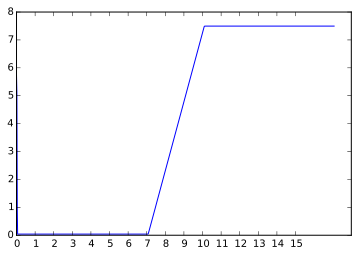

In [77]:
plot(xi,data['Xpos'][0])
xticks(range(0,16))

In [30]:
data_dict = dict()

signal_dict = dict()
[signal_dict.update({tname:list()}) for tname in trial_list]
sig_name = 'Ph1'

for fly in flylist:
    print fly.fly_num
    fly.open_fly_record()
    import os
    os.listdir(fly.fly_path)
    data = fly.get_pkl_data('nnls_fits_bk_sub_F_sig_mtrx.cpkl')

    for i,trial_type in enumerate(trial_list):
        #sca(axlist[i])
        selection = data['trial_cond'] == trial_type
        #flight_mask = np.nansum(data['wb_frequency']>150,axis = 1)>800
        #selection *= flight_mask
        signals = data[sig_name][selection]
        bsline = np.nanmean(signals[:,100:300])
        if np.isnan(bsline):
            bsline = 0
        #print bsline
        signal = np.nanmean(signals,axis = 0)-bsline
        signal_dict[trial_type].append(signal)
data_dict['wing_amp'] = signal_dict


signal_dict = dict()
[signal_dict.update({tname:list()}) for tname in trial_list]
sig_name = 'hg4'

for fly in flylist:
    print fly.fly_num
    fly.open_fly_record()
    import os
    os.listdir(fly.fly_path)
    data = fly.get_pkl_data('nnls_fits_bk_sub_F_sig_mtrx.cpkl')

    for i,trial_type in enumerate(trial_list):
        #sca(axlist[i])
        selection = data['trial_cond'] == trial_type
        #flight_mask = np.nansum(data['wb_frequency']>150,axis = 1)>800
        #selection *= flight_mask
        signals = data[sig_name][selection]
        bsline = np.nanmean(signals[:,100:300])
        if np.isnan(bsline):
            bsline = 0
        #print bsline
        signal = np.nanmean(signals,axis = 0)-bsline
        signal_dict[trial_type].append(signal)
data_dict['hg4'] = signal_dict

638
639
640
638
639
640


In [33]:
from matplotlib import gridspec
#gs = gridspec.GridSpec(len(trial_list),2)
gs = gridspec.GridSpec(2,len(trial_list))

{'ax_label': 'lwing \n amp', 'transform': <function group_data.<lambda>>}

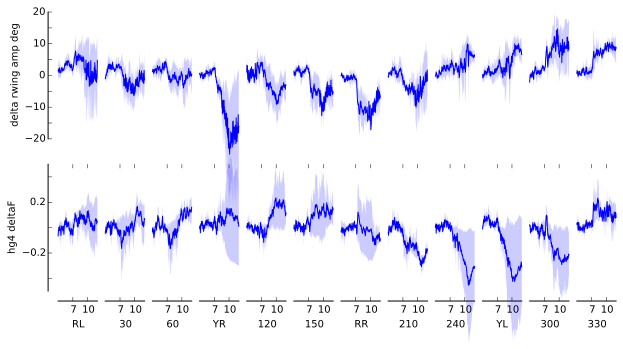

In [81]:
fig = figure(figsize = (10,5))
xi = np.linspace(0,23,1150)
sel = (xi>4) & (xi<12)
#axlist_amp = [fig.add_subplot(gs[i,0]) for i,trial_type in enumerate(trial_list)]
#axlist_hg4 = [fig.add_subplot(gs[i,1]) for i,trial_type in enumerate(trial_list)]

axlist_amp = [fig.add_subplot(gs[0,i]) for i,trial_type in enumerate(trial_list)]
axlist_hg4 = [fig.add_subplot(gs[1,i]) for i,trial_type in enumerate(trial_list)]

for i,trial_type in enumerate(trial_list):
    sca(axlist_amp[i])
    n= np.shape(data_dict['wing_amp'][trial_type])[0]
    md = np.nanmean(data_dict['wing_amp'][trial_type],axis = 0)
    ub = md + (np.nanstd(data_dict['wing_amp'][trial_type],axis = 0))#/np.sqrt(n))
    lb = md - (np.nanstd(data_dict['wing_amp'][trial_type],axis = 0))#/np.sqrt(n))
    md,ub,lb = [gd.signal_plot_info['Ph0']['transform'](x) for x in (md,ub,lb)]
    #md = np.nanpercentile(data_dict['wing_amp'][trial_type],50,axis = 0)
    #ub = np.nanpercentile(data_dict['wing_amp'][trial_type],75,axis = 0)
    #lb = np.nanpercentile(data_dict['wing_amp'][trial_type],25,axis = 0)
    fill_between(xi[sel],ub[sel],lb[sel],alpha = 0.2,lw = 0,clip_on = False)
    plot(xi[sel],md[sel],clip_on = False)
    gca().set_ybound(-20,20)
    #gca().set_ybound(150,250)
    #gca().set_ylabel(trial_to_label[trial_type])
    #gca().set_xbound(4,16)
    gca().set_xbound(4,12)
    kill_spines()
    
for i,trial_type in enumerate(trial_list):
    sca(axlist_hg4[i])
    n= np.shape(data_dict['hg4'][trial_type])[0]
    md = np.nanmean(data_dict['hg4'][trial_type],axis = 0)
    ub = md + (np.nanstd(data_dict['hg4'][trial_type],axis = 0))#/np.sqrt(n))
    lb = md - (np.nanstd(data_dict['hg4'][trial_type],axis = 0))#/np.sqrt(n))
    
    #md = np.nanpercentile(data_dict['hg4'][trial_type],50,axis = 0)
    #ub = np.nanpercentile(data_dict['hg4'][trial_type],75,axis = 0)
    #lb = np.nanpercentile(data_dict['hg4'][trial_type],25,axis = 0)
    fill_between(xi[sel],ub[sel],lb[sel],alpha = 0.2,lw = 0,clip_on = False)
    plot(xi[sel],md[sel],clip_on = False)
    gca().set_ybound(-0.5,0.5)
    gca().set_xlabel(trial_to_label[trial_type])
    gca().set_xbound(4,12)
    kill_spines()

sca(axlist_amp[0])
gca().spines['left'].set_visible(True)
gca().spines['left'].set_position(('outward',10))
[y.set_visible(False) for y in plb.gca().get_yticklabels()[1::2]]
[y.set_visible(False) for y in plb.gca().get_yticklines()[1::2]]
gca().set_ylabel('delta rwing amp deg')

sca(axlist_hg4[0])
gca().spines['left'].set_visible(True)
gca().spines['bottom'].set_visible(True)
gca().spines['left'].set_position(('outward',10))
gca().spines['bottom'].set_position(('outward',10))
[x.set_visible(False) for x in plb.gca().get_xticklabels()[1::2]]
[y.set_visible(False) for y in plb.gca().get_yticklabels()[1::2]]
[x.set_visible(False) for x in plb.gca().get_xticklines()[1::2]]
[y.set_visible(False) for y in plb.gca().get_yticklines()[1::2]]
gca().set_ylabel('hg4 deltaF')

for ax in axlist_hg4:
    sca(ax)
    gca().spines['bottom'].set_visible(True)
    gca().spines['bottom'].set_position(('outward',10))
    xticks([7,10])
    #[x.set_visible(False) for x in plb.gca().get_xticklabels()[1::2]]
    #[x.set_visible(False) for x in plb.gca().get_xticklines()[1::2]]
savefig('prelim_roll-yaw.pdf')

In [11]:
def kill_spines():
    gca().spines['left'].set_visible(False)
    gca().spines['top'].set_visible(False)
    gca().spines['right'].set_visible(False)
    gca().spines['bottom'].set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]

In [11]:
import h5py
epoch_db = h5py.File('../imaging_post_processing/epoch_db.hdf5','a')

8

In [ ]:
data = dict()
data['exp_names'] = np.array(epoch_db['exp_names'])
data['fly_numbers'] = np.array(epoch_db['fly_numbers'])
data['genotypes'] = np.array(epoch_db['genotypes'])
data['signal_data'] = np.array(epoch_db['signal_data'])
data['signal_names'] = np.array(epoch_db['signal_names'])
data['trial_names'] = np.array(epoch_db['trial_names'])

In [ ]:
def fly_medians(data,mask):
    xi = np.linspace(0,23,1150)
    baseline_epoch = (xi >5) & (xi < 7)
    ave_dict = dict()
    signal_set = set(data['signal_names'][mask])
    trial_set = set(data['trial_names'][mask])
    fly_set = set(data['fly_numbers'][mask])
    for signal in signal_set:
        ave_dict[signal] = dict()
        for trial in trial_set:
            ave_dict[signal][trial] = list()
            for fly in fly_set:
                selection = (data['fly_numbers'] == fly) & \
                            (data['signal_names'] == signal) & \
                            (data['trial_names'] == trial) & \
                            mask
                datamtrx = data['signal_data'][selection,:] 
                baseline = np.mean(data['signal_data'][selection][:,baseline_epoch],axis = 1)
                datamtrx -= baseline[:,np.newaxis]
                ave_dict[signal][trial].append(np.nanmedian(datamtrx,axis = 0)) 
    return ave_dict

In [ ]:
mask = (data['exp_names'] == 'GMR40D04_ca')